In [1]:
# https://www.kaggle.com/austinreese/craigslist-carstrucks-data
import pandas as pd
vehicles_raw = pd.read_csv('./vehicles.csv')

In [2]:
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [3]:
# We're going to drop some columns that I don't care about right away to speed things up
vehicles_raw = vehicles_raw.drop(['id', 'url', 'region', 'region_url', 'drive', 'size', 'type', 'image_url', 'description', 'county'], axis=1)

In [4]:
# We don't care if price, year, manu, model, state are null since that's where the fun is
vehicles_raw = vehicles_raw.dropna(subset=['price', 'year', 'manufacturer', 'model', 'state'])
vehicles_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404020 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         404020 non-null  int64  
 1   year          404020 non-null  float64
 2   manufacturer  404020 non-null  object 
 3   model         404020 non-null  object 
 4   condition     239678 non-null  object 
 5   cylinders     237069 non-null  object 
 6   fuel          401467 non-null  object 
 7   odometer      399883 non-null  float64
 8   title_status  396302 non-null  object 
 9   transmission  401749 non-null  object 
 10  VIN           256458 non-null  object 
 11  paint_color   282797 non-null  object 
 12  state         404020 non-null  object 
 13  lat           397865 non-null  float64
 14  long          397865 non-null  float64
 15  posting_date  404020 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 52.4+ MB


In [5]:
# Alright well why don't we look at some fun things
# Are subarus really more expensive in colorado? Why don't we find out?

# vehicles_raw['manufacturer'].value_counts() # Looks like manu names are clean, nice!
subies = vehicles_raw.loc[vehicles_raw['manufacturer'] == 'subaru']

<AxesSubplot:>

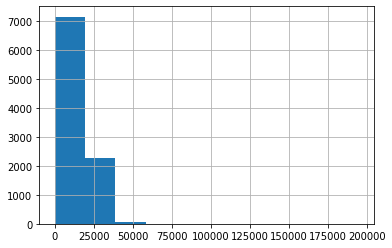

In [6]:
subies['price'].hist()

In [7]:
import numpy as np
from scipy import stats
# Well there's some bad prices here. Why don't we cut out these outliers
subies = subies[(np.abs(stats.zscore(subies['price'])) < 3)]

In [8]:
# Can we plot by lat/long? Size by price? Color by year? Why the heck not?

# Let's bound to the USA so the map looks good
subies = subies.drop(
    subies['long'].loc[(subies['long'] < -128.05) | (subies['long'] > -66.62)].index
    )

subies = subies.drop(
    subies['lat'].dropna().loc[(subies['lat'] < 23.96) | (subies['lat'] > 52.88)].index
    )

<AxesSubplot:xlabel='long', ylabel='lat'>

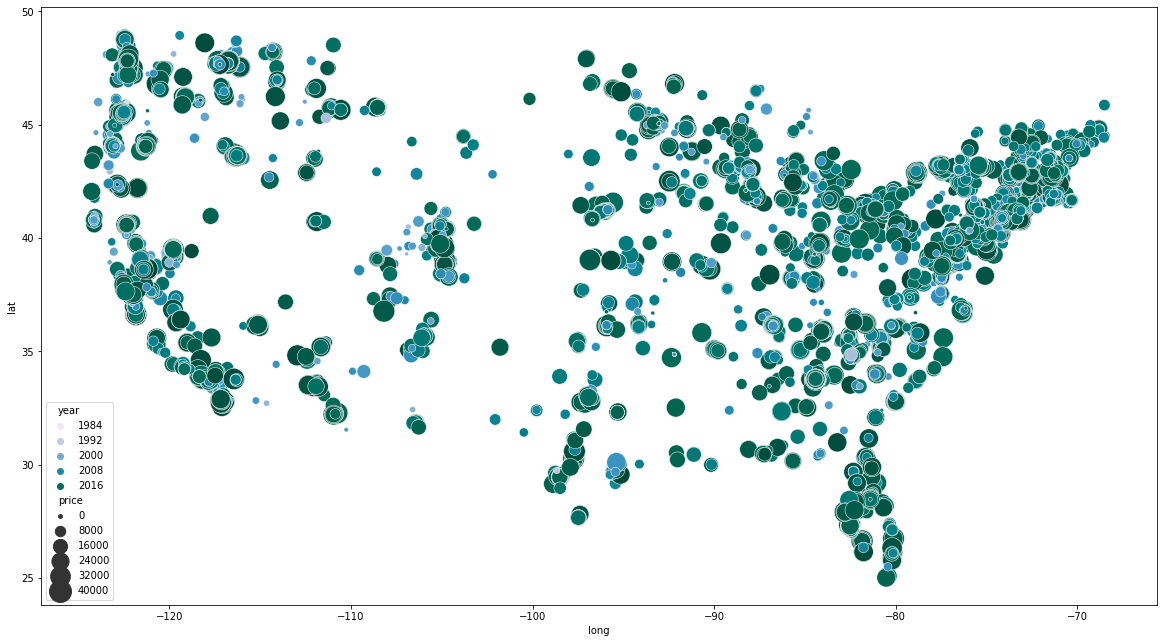

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,11))
sns.scatterplot(x=subies['long'], y=subies['lat'], size=subies['price'], sizes=(15,500), 
                hue=subies['year'], palette='PuBuGn')

<AxesSubplot:xlabel='long', ylabel='lat'>

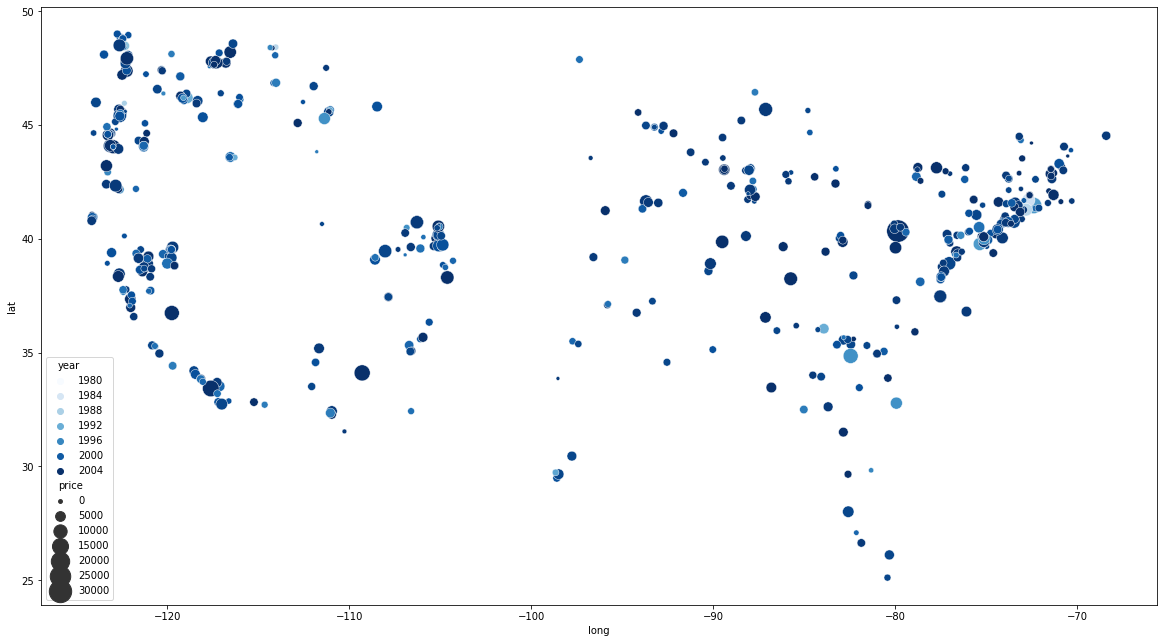

In [10]:
subies2 = subies.loc[subies['year'] < 2005]

plt.figure(figsize=(20,11))
sns.scatterplot(x=subies2['long'], y=subies2['lat'], size=subies2['price'], sizes=(15,500), 
                hue=subies2['year'], palette='Blues')

In [11]:
# Okay let's do some grouping, we want to group by CO or not CO to check against USA avg
subies['CO'] = np.where(subies['state']=='co', 'CO', 'rest')
subies = subies.groupby(['year', 'CO']).agg(avg_price=("price", 'mean'))
subies = subies.reset_index()

<AxesSubplot:xlabel='year', ylabel='avg_price'>

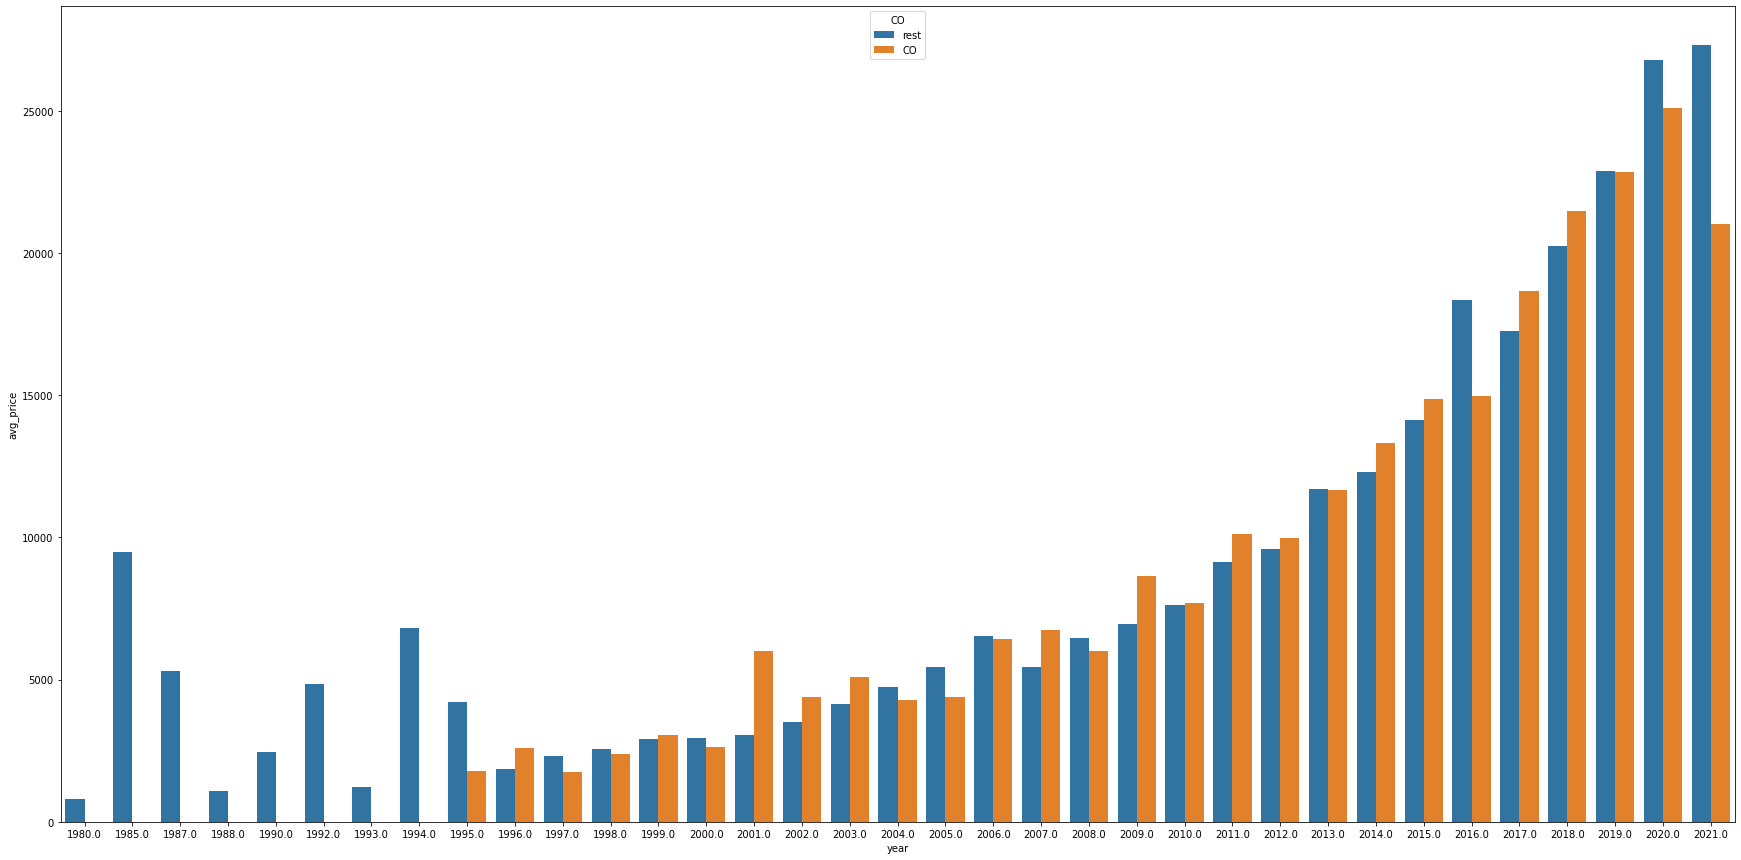

In [14]:
plt.figure(figsize=(30,15))
sns.barplot(x=subies['year'], y=subies['avg_price'], hue=subies['CO'])

In [1]:
%%markdown
I used the cars dataset. I used it because I like cars, I specifically like 90's era cars. Something about rectangles that I love. Anyways I tried to have some fun with this one. Doesn't it feel like subarus are so expensive out here? Always wanted one but I like cars that cost like 1000-2000$. Nice and rustic. Subarus are always more than that it seems. I'd be interested in the same analysis for a 4runner, ha.

First I cleaned as is tradition.

Then I tried plotting a scatter plot using the latlong coords, to show a map of the USA and where they're for sale. I tried sizing by price and coloring by year, but couldn't get it to be as distinctive as I wanted. Note the heavy volume in the NE - do they love subarus too? Like the Denver metro area that is extremely pronounced? Or is cos they rust out and people buy and sell cars more often. Anyways. Couldn't get much out of this. So I tried it again with old cars cos that's my jam, not very interesting at all. Looks expensive in Chicago.

Okay the next one I tried grouping by CO and non-CO states, and getting the average price for each model year. Then plotting them together - not as distinct as I thought. 01-03 is way more expensive here though. Coincidence? Wasn't that when they had the bug eye WRXs? Idk really.

Kinda a fun analysis, not super serious though. So many things I didn't look at. A $ doesn't go the same distance in say, CA, so I really ought to have normalized the buying power in a state or something. Also, I didn't filter out automatic transmissions, and who wants a car with that? I also filtered out things like condition, I dumped the description column and I wonder how much info you could get out of there on it's condition using some kind of NLP.

Uh for machine learning? I once tried to use this dataset to forecast prices for cars for sale on craigslist/FB marketplace, just to pick up some sweet deals on some retro boring cars. Like what if I could get a sick AWD Astrovan for like, 800$? It's hard data to work with I found out though, had little success. Everything I mentioned above plus... it's so sparse. Lots of bad values/cleaning to do. So many subjective fields. Parsing description would be so important, and would likely require a ML model on it's on to make sense of. It would be fun though.

I used the cars dataset. I used it because I like cars, I specifically like 90's era cars. Something about rectangles that I love. Anyways I tried to have some fun with this one. Doesn't it feel like subarus are so expensive out here? Always wanted one but I like cars that cost like 1000-2000$. Nice and rustic. Subarus are always more than that it seems. I'd be interested in the same analysis for a 4runner, ha.

First I cleaned as is tradition.

Then I tried plotting a scatter plot using the latlong coords, to show a map of the USA and where they're for sale. I tried sizing by price and coloring by year, but couldn't get it to be as distinctive as I wanted. Note the heavy volume in the NE - do they love subarus too? Like the Denver metro area that is extremely pronounced? Or is cos they rust out and people buy and sell cars more often. Anyways. Couldn't get much out of this. So I tried it again with old cars cos that's my jam, not very interesting at all. Looks expensive in Chicago.

Okay the next one I tried grouping by CO and non-CO states, and getting the average price for each model year. Then plotting them together - not as distinct as I thought. 01-03 is way more expensive here though. Coincidence? Wasn't that when they had the bug eye WRXs? Idk really.

Kinda a fun analysis, not super serious though. So many things I didn't look at. A $ doesn't go the same distance in say, CA, so I really ought to have normalized the buying power in a state or something. Also, I didn't filter out automatic transmissions, and who wants a car with that? I also filtered out things like condition, I dumped the description column and I wonder how much info you could get out of there on it's condition using some kind of NLP.

Uh for machine learning? I once tried to use this dataset to forecast prices for cars for sale on craigslist/FB marketplace, just to pick up some sweet deals on some retro boring cars. Like what if I could get a sick AWD Astrovan for like, 800$? It's hard data to work with I found out though, had little success. Everything I mentioned above plus... it's so sparse. Lots of bad values/cleaning to do. So many subjective fields. Parsing description would be so important, and would likely require a ML model on it's on to make sense of. It would be fun though.
